# Sesion 1: Taller de tecnicas de modelado de fluidos

## Solución Numérica usando el Método de Elementos Finitos (Galerkin Discontinuo)

**Por: Erick Urquilla, Universidad de Tennessee, Knoxville, USA**

Las ecuaciones de aguas poco profundas gobiernan la dinámica de fluidos en capas delgadas, limitadas inferiormente por una superficie rígida y superiormente por una superficie libre. Estas se derivan de las ecuaciones de Navier-Stokes cuando el dominio espacial horizontal del fluido excede significativamente al vertical, manteniendo el equilibrio hidrostático y densidad constante.

$$
\frac{\partial h}{\partial t} + \frac{\partial}{\partial x}\left(hu\right) = 0
$$
$$
\frac{\partial}{\partial t}\left(hu\right) + \frac{\partial}{\partial x}\left(hu^2 + \frac{gh^2}{2}\right) = 0
$$

Aquí, $h$ es la altura del fluido, $u$ es la velocidad horizontal y $g$ es la aceleración de la gravedad. El movimiento del fluido está dictado exclusivamente por las ecuaciones de conservación de masa y momento.

## Paquetes Utilizados

En este proyecto, utilizaremos varios paquetes de Python que nos ayudarán a realizar diferentes tareas de manera eficiente. A continuación, se describen los paquetes que se utilizarán:

1. **numPy**
2. **matplotlib**
3. **time**

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

## Scripts Utiliados

En esta sesion importaremos los siguientes scripts

1. **basis**
2. **evolve**
3. **integrator**

Puedes encontrar estos scripts en la misma ruta que este notebook

In [10]:
import basis
import evolve 
import integrator

## Parámetros de entrada

1. Dominio espacial de la simulación
2. Número de elementos y número de nodos interiores por elemento
3. Tiempo de la simulación y número de pasos
4. Número de puntos en la cuadratura de Gauss para integración numérica

In [11]:
# Parametros de entrada

# Dominio espacial de la simulacion 
x_initial = 0 # (m) cooordenda inicial del dominio
x_final = 10 # (m) coordenada final del dominio

# Parametros del metodo de elementos finitos
N_elements= 10 # numero de elementos
N_nodos = 3 # numero de nodos por elemento
p_basis_order = N_nodos - 1 # Orden de los polinomios de lagrange para la base

# Dominio temporal 
n_steps = 200 # numero de pasos temporales
t_limit = 1 # (s) tiempo final

# Integracion numerica con cuadratura de Gauss
n_gauss_poins = 20

## Generacion de cuadricula de elementos

La generación de una malla y una cuadrícula es fundamental en el método de elementos finitos, especialmente en el método de Galerkin discontinuo (DG), por varias razones:

1. **Discretización del dominio**: La malla divide el dominio continuo en elementos finitos más pequeños, lo que permite aproximar la solución de la ecuación diferencial en cada uno de estos elementos. En el método DG, cada elemento puede tener su propia solución polinómica, lo que permite capturar discontinuidades y variaciones abruptas en la solución.

2. **Flexibilidad en la representación**: La cuadrícula permite representar geometrías complejas y adaptarse a diferentes escalas de variación en la solución. Esto es especialmente útil en problemas donde la solución tiene características locales que requieren una mayor resolución.

3. **Precisión y convergencia**: Una malla bien diseñada puede mejorar la precisión de la solución y la tasa de convergencia del método numérico. En el método DG, la elección de la malla y el orden de los polinomios en cada elemento son cruciales para obtener resultados precisos.

4. **Implementación de condiciones de contorno**: La malla facilita la implementación de condiciones de contorno, ya que permite definir claramente los límites del dominio y aplicar las condiciones adecuadas en los nodos correspondientes.

5. **Paralelización y eficiencia computacional**: La estructura de la malla permite dividir el problema en subproblemas más pequeños que pueden ser resueltos en paralelo, mejorando la eficiencia computacional. En el método DG, cada elemento puede ser tratado de manera independiente, lo que facilita la paralelización.

En resumen, la generación de una malla y una cuadrícula es un paso esencial en el método de elementos finitos, ya que permite discretizar el dominio, representar la solución con flexibilidad, mejorar la precisión y eficiencia computacional, y aplicar condiciones de contorno de manera efectiva.

In [21]:
def generate_1d_mesh(initial_coord, final_coord, num_elements, num_nodos_interiores):
    """
    Genera una malla unidimensional (1D) en el dominio físico especificado.

    @param initial_coord: Coordenada inicial del dominio físico.
    @param final_coord: Coordenada final del dominio físico.
    @param num_elements: Número de elementos en la malla.
    @param basis_order: Orden de la base de Lagrange.

    @return: Coordenadas de los nodos en el espacio físico.
    """
    
    print(f'Generando malla \nDominio físico: [{initial_coord},{final_coord}] metros\nNúmero de elementos: {num_elements}\nNodos por elemento: {num_nodos_interiores}\nOrden de la base de Lagrange: {num_nodos_interiores - 1}\n')

    basis_order = num_nodos_interiores - 1

    # Generar coordenadas de los elementos
    elements_division = np.linspace(initial_coord, final_coord, num_elements + 1)

    # Calcular las coordenadas de los nodos en el espacio físico dentro de cada elemento
    if basis_order != 0:
        nodes_coord_phys_space = np.array([np.linspace(elements_division[i], elements_division[i + 1], basis_order + 1) for i in np.arange(num_elements)])
    else:
        nodes_coord_phys_space = np.array([[elements_division[i] + 0.5 * (elements_division[i+1] - elements_division[i])] for i in np.arange(num_elements)])

    return nodes_coord_phys_space

nodes_coordinates_phys_space = generate_1d_mesh(x_initial, x_final, N_elements, N_nodos)

# Imprimir las coordenadas de los nodos en el espacio físico
for i in range(N_elements):
    print(f'Nodos interiores de elemento {i}: {nodes_coordinates_phys_space[i]}')

Generando malla 
Dominio físico: [0,10] metros
Número de elementos: 10
Nodos por elemento: 3
Orden de la base de Lagrange: 2

Nodos interiores de elemento 0: [0.  0.5 1. ]
Nodos interiores de elemento 1: [1.  1.5 2. ]
Nodos interiores de elemento 2: [2.  2.5 3. ]
Nodos interiores de elemento 3: [3.  3.5 4. ]
Nodos interiores de elemento 4: [4.  4.5 5. ]
Nodos interiores de elemento 5: [5.  5.5 6. ]
Nodos interiores de elemento 6: [6.  6.5 7. ]
Nodos interiores de elemento 7: [7.  7.5 8. ]
Nodos interiores de elemento 8: [8.  8.5 9. ]
Nodos interiores de elemento 9: [ 9.   9.5 10. ]


## Condiciones initiales

La función `generate_initial_conditions` tiene como objetivo generar las condiciones iniciales de altura y velocidad en función de las coordenadas de los nodos de todos los elementos.

### Desglose de la función:

1. **Definición de la altura inicial:**
    ```python
    def initial_height(x):
        h = 1 + 0.1 * np.exp(-(x - 5) ** 2)
        return h
    ```
    Esta función interna `initial_height` calcula la altura inicial `h` en función de la coordenada `x`. Utiliza una fórmula que incluye una constante base de 1 y un término exponencial que depende de la distancia de `x` al valor 5.

2. **Definición de la velocidad inicial:**
    ```python
    def velocity_initial(x):
        u = 0
        return u
    ```
    Esta función interna `velocity_initial` asigna una velocidad inicial `u` de 0 para cualquier valor de `x`.

3. **Asignación de la altura y velocidad inicial en cada nodo de los elementos:**
    ```python
    h_height = [np.array([initial_height(x_n) for x_n in nodes_in_elem]) for nodes_in_elem in nodes_coords_all_elem]
    u_velocity = [np.array([velocity_initial(x_n) for x_n in nodes_in_elem]) for nodes_in_elem in nodes_coords_all_elem]
    ```
    Aquí se crean listas de arrays de NumPy que contienen las alturas y velocidades iniciales para cada nodo en cada elemento. Se utiliza una comprensión de listas para aplicar las funciones `initial_height` y `velocity_initial` a cada coordenada `x_n` en los nodos de cada elemento.

4. **Conversión a arrays de NumPy:**
    ```python
    h_height = np.array(h_height)
    u_velocity = np.array(u_velocity)
    ```
    Las listas de alturas y velocidades se convierten en arrays de NumPy para facilitar su manipulación y cálculo posterior.

5. **Retorno de las condiciones iniciales:**
    ```python
    return h_height, u_velocity
    ```
    La función retorna dos arrays: `h_height` con las alturas iniciales y `u_velocity` con las velocidades iniciales.

### Generación de las condiciones iniciales:
```python
h, u = generate_initial_conditions(nodes_coordinates_phys_space)

In [13]:
h = 1.0 + 0.1 * np.exp( - ( nodes_coordinates_phys_space - 5.0 )**2 ) # Height (cm)
u = nodes_coordinates_phys_space * 0.0 # Velocity (cm/s)

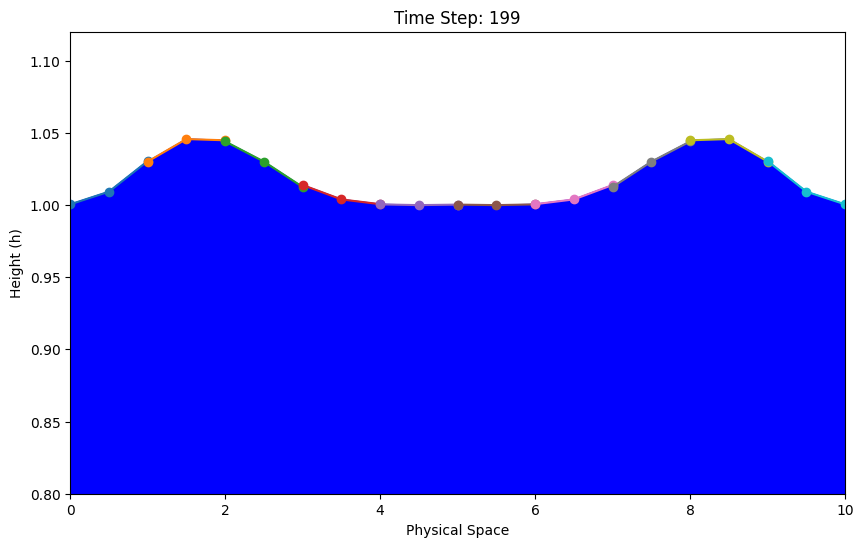

Done


In [14]:
element_number = np.arange(N_elements)
element_lengths = nodes_coordinates_phys_space[:,-1] - nodes_coordinates_phys_space[:,0]

# generating reference space information
gauss_weights, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, basis_values_at_nodes = basis.generate_reference_space(nodes_coordinates_phys_space, n_gauss_poins)

# compute mass matrix M_ij = integral phi_i(x) phi_j(x) dx and return the inverse matrix of M_ij
mass_matrix_inverse = evolve.compute_mass_matrix_inverse(element_lengths, gauss_weights, basis_values_at_gauss_quad)

# time step
time_step = np.array(t_limit/n_steps) 


# evolving in time the PDE
for number_of_t_step in np.arange(n_steps):

    # plotting

    clear_output(wait=True)  # Clear the output of the current cell    
    plt.figure(figsize=(10, 6))
    plt.clf()  # Clear the current figure
    for i in range(N_elements):
        plt.plot(nodes_coordinates_phys_space[i], h[i], linestyle='-', marker='o')
        plt.fill_between(nodes_coordinates_phys_space[i], h[i], 0, color='blue')
    plt.ylim(0.8, 1.12)
    plt.xlim(0.0, 10.0)
    # plt.gca().set_aspect('equal', adjustable='box')  
    plt.xlabel('Physical Space')
    plt.ylabel('Height (h)')
    plt.title(f'Time Step: {number_of_t_step}')
    # plt.legend()
    # plt.grid(True)
    plt.show()
    time.sleep(0)  # Pause for a second to see the change

    # saving the data
    # if (number_of_t_step+1) % plot_every_steps == 0 or number_of_t_step == 0:

        # print(f'Number of time step : {number_of_t_step+1} / {n_steps}')

        
    # If true using euler method
    # if evolution_method==0:
    #     h, u = integrator.euler_method( h, u, time_step, element_number, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, gauss_weights, element_lengths, basis_values_at_nodes, mass_matrix_inverse)

    # If true using RK4 method
    # if evolution_method==1:
    h, u = integrator.rk4_method( h, u, time_step, element_number, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, gauss_weights, element_lengths, basis_values_at_nodes, mass_matrix_inverse)

    # compute entropy : integral 0.5 * ( g * h**2 + h * u ) dx
    # entropy = evolve.compute_entropy(element_lengths, gauss_weights, basis_values_at_gauss_quad, h, u)

    # writing data
    # integrator.write_data_file(nodes_coordinates_phys_space,entropy,h,u,False,number_of_t_step+1, t_limit, n_steps)

print(f'Done')